# Individual Analysis for the Zeeman Effect

Use this template to carry out the analysis tasks for the experiment.  You may need to consult the documentation for different Python packages.  Also recommended: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will also be using [**LMFit**](https://lmfit.github.io/lmfit-py/) for curve fitting 
and the [Uncertainties](https://pythonhosted.org/uncertainties/) package for calculating statistical uncertainty. 

Import a range of useful Python Libraries:

In [1]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Summary of tasks

### Prior to working on this notebook

Make sure you understand the concept of the <i>free spectral range</i> and the general idea of how to obtain a wavelength or energy shift from the Zeeman spectrum data.

Calculate the $g$ factors and the energys shifts $\Delta E_m$ for the three different Hg transitions studied: the 541 nm green line, and the two yellow lines, 577 nm and 579 nm.  Your energy shift predictions should be in units of $\mu_BB$.

You will need the above calculations to check against the measures and analyzed values.

### Tasks for this notebook

**Before analyzing the scans**

Read in the Fabry-Perot mirror position data.  Calculate the mirror spacing and the free spectral range in units of hertz.

Based on the magnet calibration curve coefficients, create a magnet calibration function that converts magnet current (in amperes) to magnetic field (in tesla).  Your calibration should propagate the uncertainty in the current to the uncertainty in the B-field.

Combine the magnetic field $B$ with the Bohr magneton $\mu_B$ to obtain an energy unit $\mu_BB$ for the green line at 3.612 A and for the yellow lines at 1.817 A.  This unit sets the scale for the magnetic energy. HINT: use the value of $\mu_B$ in Hz/T.  Then you don't need to convert FSR to actual energy units.

**For the green lines**

Read in two data files for green: $I=0$ and $I=3.612$ A with no polarizer.  Trim the data sets to cut off partial patterns and the reset portion.  Plot the two data sets on a single graph, vertically separated and scaled so that the scans can be easily compared by eye.  The x axis can be the array index.

Analyze the $I=0$ data set as follows:

1. Smooth the data set with SciPy `gaussian_filter1d()`.  Use minimal gaussian width to preserve scan detail.
2. Locate the central peaks of each cycle, using the SciPy `find_peaks()` function.  From the return result of `find_peaks()` determine the average FWHM (units of array index) and the average separation of the peaks.  Plot this in a way that shows the measured widths and peak positions. 
3. The ratio of the average separation to the FWHM gives the instrument <i>finesse</i>.  Calculate this.

Analyze the $I=6.612$ A scan with no polarizer, as follows:

1. Smooth the data set with SciPy `gaussian_filter1d()`.  Use minimal gaussian width (e.g, 2 to 4) to preserve scan detail.
2. Apply the `find_peaks()` function to all of the prominent peaks in the scan.  There should be 9 peaks per cluster for a total of 36 identified peaks.  Plot the data with markers to locate the identified peak positions to check that you got the correct peaks.
3. Locate the central peaks of each cycle.  These peaks will be used to calibrate the scan.  They can be accessed from the `peaks` array returend by `find_peaks()` with a slice that starts with the first central peak (e.g., at index 4) and skips by the number of peaks between the first central peak and the second central peak (e.g., by 9).  For example `peaks[4::9]` would grab the locations of the central peaks as described.
4. Number the central peak positions sequentially (first central peak is 1, second is 2, etc.). Plot and fit the peak number versus the measured position with a 3rd order polynomial.  This will create a nonlinear calibration function that converts the array indices to units of the free spectral range, and it corrects for the hysteresis in Fabry-Perot scan.
5. Replot the scan in terms of free-spectral-range units.  It should look more uniform along the x axis.  You will need to generate an x-axis array that has the same indices as the scan array.
6. Convert the peak locations to units of the free spectral range (FSR).  Create a table (DataFrame table is nice) that lists the 36 peak positions in terms of `peaks` number and FSR.  Check that the central peaks are located at FSR units of 1.0, 2.0, etc. (or very close).
7. Calculate the separation between each satellite peak and its associated central peak.  Combine the separation values for the same satellite from each cluster to make an average separation from the center for that satellite. For example in the first cluster, there is a satellite immediately to the left, separated by a certain distance.  In every other cluster there is the same satellite with the same separation.  Combine the separations from all of these to get the average separation for that satellite.  These separations will all be in units of the free spectral range, and be fractions (positive and negative) of the free spectral range.
8. Convert the separations in FSR units to separations in $\mu_BB$ energy units.  You will need a conversion factor based on how many of $\mu_BB$ fit into one FSR.
9. Finally make a table that lists the separations in terms of satellite number, separation in FSR, and separation in $\mu_BB$, and include a column of the theoretical separation in units of $\mu_BB$ to compare. 

**For the yellow lines**

Read in two data files for yellow: $I=0$ and $I=1.817$ A with no polarizer.  Trim the data sets to cut off partial patterns and the reset portion.  Plot the two data sets on a single graph, vertically separated and scaled so that the scans can be easily compared by eye.  The x axis can be the array index.  (It is helpful to align the central peaks from the two scans to identify wich peaks are from 577 nm and which are from 579 nm.)

Analyze the $I=1.817$ A scan with no polarizer in the same way as above for steps 1 & 2.  There will be 24 total peaks.

Then, separate the peak sets into two groups, one group of 12 peaks will correspond to the 577 nm line, and the other 12 will correspond to the 579 nm line.  These groups must be analyzed separately.  For each group, follow the plan of steps 3 through 9, except you will have clusters of 3 peaks instead of 9 peaks to sort out.



## Free spectral range

Calculate the free spectral range of the Fabry-Perot etalon in hertz (Hz), and print it out in gigahertz (GHz).  The formula is

$$\text{FSR} = \frac{c}{2d}$$

where $d$ is the mirror separation, and $c$ is the speed of light.

In [36]:
## Read in the mirror positions

#Mirror_sep = pd.read_csv("Mirror_Separation.csv") 

## Calculate the differences
#d_array = np.array(Mirror_sep['Stop'] - Mirror_sep['Start']) + 1000

## Calculate then mean value of the differences and the 
## standard deviation of the mean of the differences.
## Convert values to meters

#mirror positions
ed_array=[1.645,1.640,1.735,1.660,1.675]
d_array=np.array(ed_array)
d = d_array.mean()

sigma_d = d_array.std()

## make an uncertainty object
ud = unc.ufloat(d,sigma_d)

## Calculate the free spectral range in Hz 

uFSR = ((2.998*(10**8))*(1000))/(2*ud)
uFSR
## Print out the mirror separation and the FSR
print('Mirror separation: {:.2uP} mm'.format(ud))
print('Free spectral Range: {:.2uP} GHz'.format(uFSR/const.giga))

Mirror separation: 1.671±0.034 mm
Free spectral Range: 89.7±1.8 GHz


## Magnetic Field

From the calibration curve shown in the instructions, create a polynomial function to convert current to magnetic field in Tesla.

Advice: look up `np.poly1d()`.  This allows you to build a function from a list of coefficients.  **Make sure you enter them in the correct order!**

In [3]:
# Coefficiants from fit to magnetic field data come from from instructions 
coeffs = [-9.4193, 33.556, 375.66, 42.845] # values give millitesla

# poly1d() creates a polynomial function
#
# Convert coefficients to give field in tesla with 'const.milli'
B_coeff = np.asarray(const.milli) * coeffs
B = np.poly1d(B_coeff)

Use the finction to calculate the field for the two different scan files

In [4]:
# Green peaks current & field
I_green = 3.069 # current in green line measurement, Amps
sigma_I_green = 0 # Amps

# Make uncertainty object
unc_I_green = unc.ufloat(I_green,sigma_I_green)

B_green = B(unc_I_green)

print('Field strength at {:.1uP} A = {:.2uP} mT'.format(unc_I_green,B_green/const.milli))

Field strength at 3.069±0 A = (1.2395255263054763±0)×10³ mT


In [5]:
# Yellow peaks current & field
I_yellow = 3.042 # current in yellow line measurement, Amps
sigma_I_yellow = 0 # Amps

# Make uncertainty object
unc_I_yellow = unc.ufloat(I_yellow,sigma_I_yellow)
# Copy from above

B_yellow = B(unc_I_yellow)

print('Field strength at {:.1uP} A = {:.2uP} mT'.format(unc_I_yellow,B_yellow/const.milli))

Field strength at 3.042±0 A = (1.2309691999201016±0)×10³ mT


### Conversion factors

Under the SciPy constants, one can obtain the Bohr magneton in unist of Hz/T.  This allows $\mu_BB$ to be expressed in frequency units, which are the same units as the FSR.

In [6]:
print('mu_B = {:.6g} Hz/T'.format(const.value(u'Bohr magneton in Hz/T')))

mu_B = 1.39962e+10 Hz/T


Create conversion factors to convert FSR units to units of $\mu_BB$.  These will be used later.

In [41]:
conv_fact_green = uFSR/(const.value(u'Bohr magneton in Hz/T') * B_green)
print('Conversion factor for green lines (Free spectral range in units of B*mu_B): {:.1uP}'.format(conv_fact_green))

conv_fact_yellow = (const.value(u'Bohr magneton in Hz/T') * B_yellow)/uFSR
print('Conversion factor for yellow lines (Free spectral range in units of B*mu_B): {:.1uP}'.format(conv_fact_yellow))

Conversion factor for green lines (Free spectral range in units of B*mu_B): 5.2±0.1
Conversion factor for yellow lines (Free spectral range in units of B*mu_B): 0.192±0.004


## Green Line Analysis

### Read in the data

Read important data files into Pandas "DataFrames" 

In [8]:
# df = pd.read_csv(file,skiprows=15)  # skiprows skips header information.
Green_pi = pd.read_csv('T0014CH1_greenpipolarized1.csv')
Green_sigma = pd.read_csv('T0013CH1_greensigmapolarized1.csv')
Green_no_field = pd.read_csv('T0010CH1_greennofield1.csv')
Green_field = pd.read_csv('T0012CH1_greenwithfield1.csv')
# Collect the data sets into dataframes.
#Green_B0 = pd.read_csv('Green_B0.csv', skiprows=15) 
#Green_3612 = pd.read_csv('Green_3612A_no_polarizer.csv', skiprows=15) 
Green_pi

,TIME,CH1
0,0.0124,0.004336
1,0.0124,0.004016
2,0.0125,0.005000
3,0.0125,0.004414
4,0.0125,0.004625
...,...,...
3120,0.1120,0.055719
3121,0.1120,0.062062
3122,0.1120,0.084969
3123,0.1120,0.101320


Graph the data to see what it looks like.  Cell below sets defaults for graphs.

<AxesSubplot:title={'center':'Green Without Field'}, xlabel='TIME'>

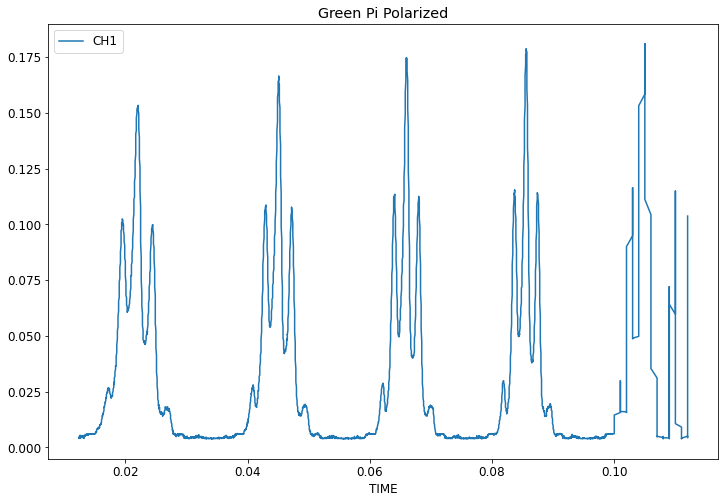

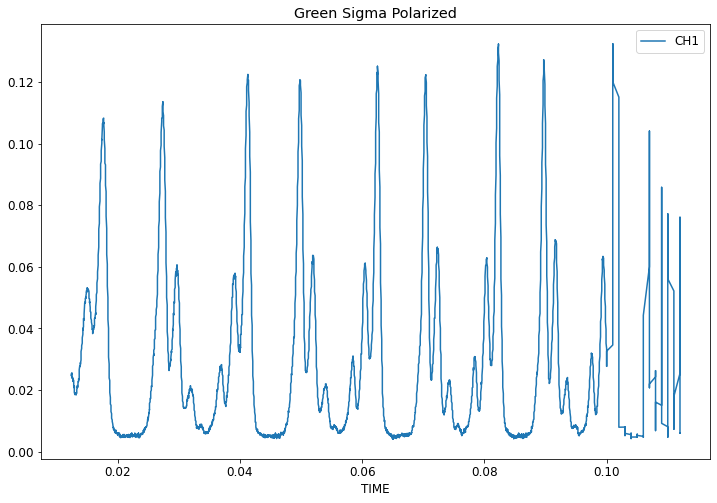

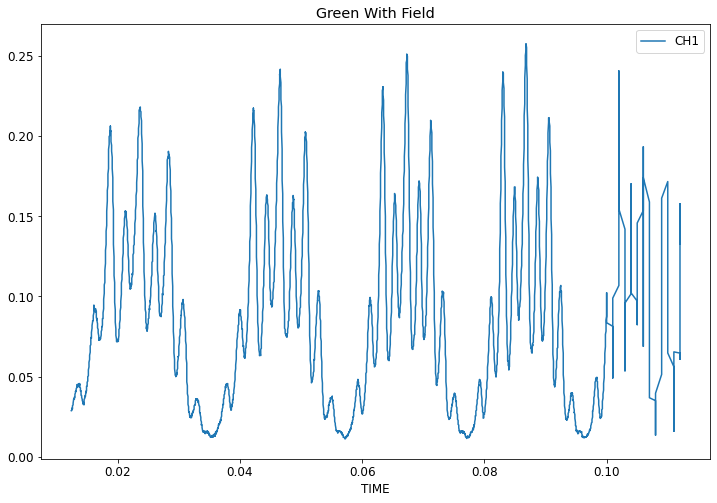

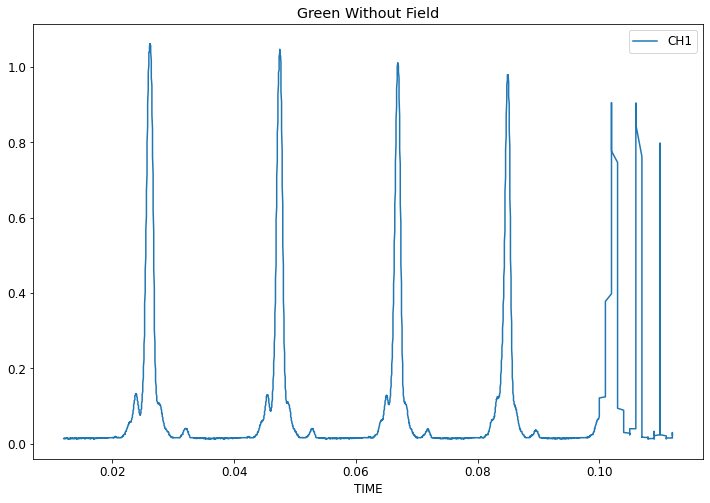

In [9]:
# Use base library to set up plot size and default font size
# Only need to do this once in a notebook
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 12.0 # Use 12 point font

Green_pi.plot(x = 'TIME', y = 'CH1', title ='Green Pi Polarized')
Green_sigma.plot(x = 'TIME', y = 'CH1', title ='Green Sigma Polarized')
Green_field.plot(x = 'TIME', y = 'CH1', title ='Green With Field')
Green_no_field.plot(x = 'TIME', y = 'CH1', title ='Green Without Field')


### Normalize the data sets

Adjust the data sets to normalize the heights to the maximum height and trim the indices to select only the useful range of data.  This is best done by eye: plot the data, then pick a start and end for the slice, replot, and iterate the slice until it looks good.  To normalize an array `ydata` to make all values lie between 0 and 1, you can do this:
```
y_norm = (ydata - ydata.min())/(ydata.max()-ydata.min())
```

Hint: make the above into a function you can reuse!

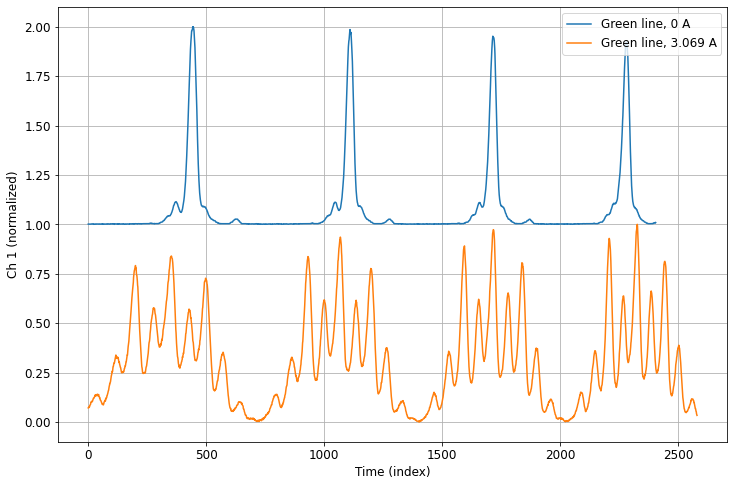

In [37]:
# Build normalized and trimmed data: normalize-scale and slice the data sets
# Slice found by eye with iteration on plot
# Put into new numpy array to reset indices to start at zero

def normalize_array(ydata):
    '''
    Normalizes data set to lie within [0,1] range
    '''
    normed_data = (ydata - ydata.min())/(ydata.max() -ydata.min())
    return normed_data


## Make sure you have a clean slice, then normalize and save
sl_B = Green_field[Green_field.TIME < 0.095]
sl_0 = Green_no_field[Green_no_field.TIME < 0.089]

gr_B = normalize_array(sl_B['CH1']) #normalized and clipped graph with an applied magnetic field
gr_0 = normalize_array(sl_0['CH1']) #normalized and clipped graph with no applied magnetic field

## Then plot
## Note: no use of x-array.  Use of indices makes setting slice easier
plt.xlabel(r'Time (index)')
plt.ylabel(r'Ch 1 (normalized)')
## Offsets gr_0
plt.plot(1.0+gr_0, '-',  label='Green line, 0 A')
plt.plot(gr_B,'-', label='Green line, 3.069 A')
plt.legend() 
plt.grid(); 

### Green, no magnet current

Analyze this by finding peaks and their FWHM.  Use to calculate the instrument *finesse*.

Hint: use function for finding and plotting peaks from the HD spectrum lab. You may need to modify it to deal with these different data sets.

In [11]:
## Function to locate the peaks, plot them, and return the important data
from scipy.signal import find_peaks

## function to smooth data with gaussian convolution.
from scipy.ndimage import gaussian_filter1d

def find_and_plot_peaks(ydata, title='Data', makeplot=True, min_width=40, min_dist=10, rel_prom=0.5, smoothing=1):
    '''
    Function locates peaks using SciPy.signal find_peaks() and plots
    the results (optionally).  Returns two arrays: 'peaks' which holds
    the index of each peak maximum and 'widths' which holds the FWHM of
    each peak.
    '''
    # Below does the work.  The height parameter makes the function only look 
    # for peaks higher than halfway up the tallest peak.
    
    smooth_data = gaussian_filter1d(ydata,smoothing)

    peaks, pk_props = find_peaks(smooth_data, width = min_width, distance=min_dist, prominence=ydata.max()*rel_prom)
    
    height = []
    ix = 0
    print('Peak  Loc   Width   Height')
    for pk, prop in zip(peaks, pk_props['widths']): 
        ix += 1
        print('{:3d}  {:4d} {:7.1f}  {:6.2f}'.format(ix, pk, prop, ydata[pk]))
        height.append(ydata[pk])
    if makeplot:
        plt.grid()
        plt.title('Peak finding for '+title)
        plt.ylabel(r'Intensity (normalized)')
        plt.xlabel(r'Array index')
        plt.plot(ydata,'-',label='Data')
        plt.plot(peaks, ydata[peaks],'o', color='C1', label='Locations')
        plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
                   xmax=peaks+pk_props['widths']/2, color = 'C3', label='Widths')
        plt.legend();
    
    return peaks, pk_props['widths'], height

Peak  Loc   Width   Height
  1   444    39.5    0.99
  2  1109    35.7    0.99
  3  1715    34.0    0.95
  4  2280    33.1    0.92


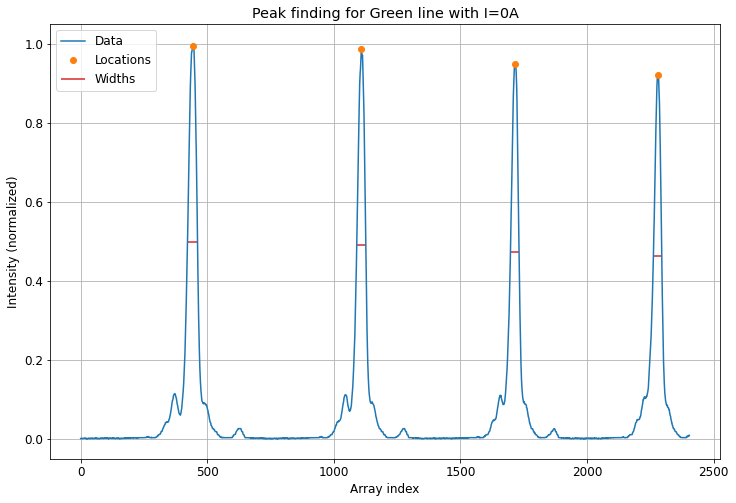

In [12]:
# Smoothing function applied to improve peak-center location
# You will need to set parameters as well as data file

peaks,widths, height = find_and_plot_peaks(gr_0,min_width=10,min_dist=50,title='Green line with I=0A')

### Find the average peak spacing

Use a line fit with the peak position vs. peaks labeled 1, 2, 3, 4, as done in earlier labs.


In [13]:
from lmfit.models import LinearModel

line = LinearModel()

## Recommended:
## Make a function to do the work, with model as a passed object.
## The return is the fit parameters structure

def model_fit_and_plot(xdata, ydata, model=LinearModel()):
    '''
    Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters
    '''
    param_guess = model.guess(ydata, x = ydata)
    model_fit = model.fit(ydata, param_guess, x = xdata)
    # Complete the function
    return model_fit.params

Use the above function to fit the line

In [14]:
## Call model_fit_and_plot()
## You will need a list of whole numbers from 1 to the number of peaks as the x-axis
peaks_number = []
for i in range(len(peaks)):
    peaks_number.append(i)
gr0_line = model_fit_and_plot(peaks, peaks_number)

From the fit, calculate the average peak spacing and the instrument finesse.

In [15]:
##  Building uncertainty objects allows for statistical uncertainty in the finesse.

ave_separation = gr0_line['slope']
ave_width = widths.mean()

print('\nEXERCISE 1: FROM ANALYSIS OF GREEN LINE WITH I=0')
print('Instrument finesse =  {:1}'.format(ave_separation/ave_width))


EXERCISE 1: FROM ANALYSIS OF GREEN LINE WITH I=0
Instrument finesse =  4.5951339471137074e-05


## Green line with field on

Now find the peaks in the scan with $I=3.612$ A.  There are 36 good ones.  You will need to adjust the minimum height parameter or prominence parameter in order to get the small ones.

Peak  Loc   Width   Height
  1    37    29.8    0.14
  2   120    25.1    0.33
  3   199    38.9    0.78
  4   278    25.8    0.57
  5   352    57.6    0.84
  6   428    29.7    0.57
  7   498    34.1    0.73
  8   570    30.4    0.34
  9   642    27.1    0.10
 10   795    25.0    0.14
 11   863    23.5    0.33
 12   931    33.4    0.84
 13  1000    24.4    0.61
 14  1067    46.8    0.92
 15  1135    26.4    0.62
 16  1198    30.4    0.77
 17  1264    27.2    0.37
 18  1330    25.3    0.10
 19  1466    23.2    0.15
 20  1529    23.1    0.35
 21  1592    29.3    0.88
 22  1654    22.6    0.62
 23  1716    41.9    0.97
 24  1779    25.1    0.65
 25  1839    28.2    0.80
 26  1899    25.6    0.37
 27  1959    23.9    0.12
 28  2089    22.1    0.15
 29  2147    22.7    0.36
 30  2207    27.8    0.93
 31  2267    21.5    0.64
 32  2325    36.6    0.99
 33  2385    24.0    0.66
 34  2442    27.2    0.81
 35  2501    24.6    0.38
 36  2559    22.5    0.12


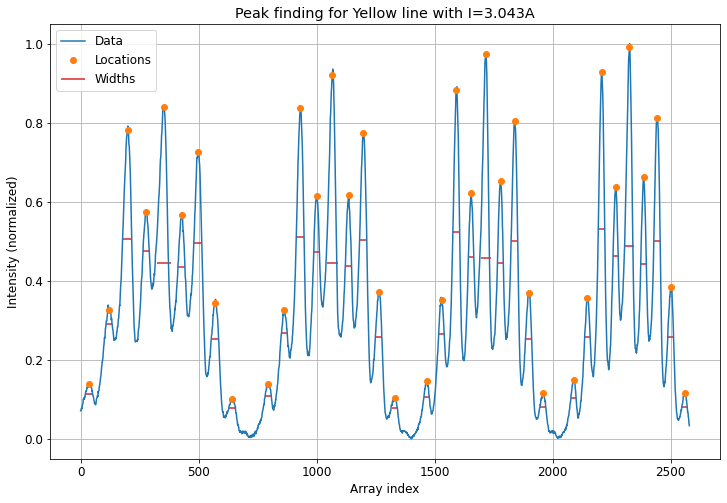

In [38]:
## Call the peak finding routine with the other data set.
peaks,widths, height = find_and_plot_peaks(gr_B, min_width=0, min_dist= 50, title = 'Green line with I = 3.069A', rel_prom = .01)


### Create nonlinear calibration

First select the central peak locations in each cluster.  Do this with a slice, i.e., `centrals = peaks[4::9]`.  Check the numbers against the plot to make sure they look right. 

Then fit the peak numbers (1,2,3,4) against the locations with a polynomial of degree 3.  Each number represents a change in energy by one FSR.  

In [17]:
## Locate the central peaks in the `peaks` array and print them.
centrals = peaks[4::9]
print('Location of cetral peaks in each cluster: ',centrals)

Location of cetral peaks in each cluster:  [ 352 1068 1717 2326]


Now fit to a polynmial of degree 3.

In [18]:
## Import the model
from lmfit.models import PolynomialModel

## set the model to make a 3rd-order ploynomial
curve = PolynomialModel(degree=3)

num = []
for i in range(len(centrals)):
    num.append(i)
## Fit.  NOTE: the y-values should be the list of integers (peak numbers), and the x-values 
## should be the peak locations.
green_curve = model_fit_and_plot(centrals, num, model = curve)


### Calibration function & Replot

Use `eval()` to turn array index into units of FSR.  

Then make an x-array that has values of the FSR for the same range of indicies, and plot the green-lines array against this FSR-valued array.  You should see the peaks become evenly space on this plot with the central peaks located at 1.0, 2.0, 3.0 and 4.0.

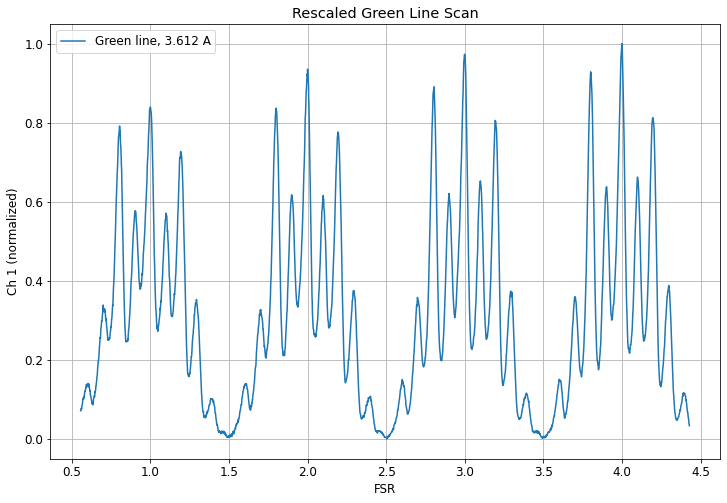

In [19]:
## Make the calibration function, let eval() do the work.  
## This way you do not need to directly deal with the fit coefficients
def green_cal(x,model=curve,params=green_curve):
        return model.eval(params, x=x)

## Make an x-value array from the calibration function.  
## This array will reset the horizontal axis to units of FSR

indices = []
for i in range(len(gr_B)):
    indices.append(i)
x_0 = green_cal(indices) #the x value in the calibration function are the indicies

# Plot the data against the rescaled axis.
plt.title('Rescaled Green Line Scan')
plt.xlabel(r'FSR')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(x_0 + 1, gr_B,'-', label='Green line, 3.612 A')
plt.legend() 
plt.grid(); 


### Make a table of peak locations

Apply the calibration to all of the peak locations.  Load the results into a table and display.  You should see the central peaks have locations of 1, 2, 3, 4 (or very close).  Hint: inlcude the heights at these locations to help identify peaks.

In [20]:
## Make a table and show it.
peaks_calibrated = []
for i in range(len(peaks)):
    peaks_calibrated.append(green_cal(peaks[i]))
height = np.round(height, decimals = 2)
Green_scan_peaks = pd.DataFrame(list(zip(peaks_calibrated, height)), columns = ['FSR', 'Height']
 ## Complete the dataframe
)
Green_scan_peaks

,FSR,Height
0,-3.974579e-01,0.14
1,-3.000444e-01,0.34
2,-1.958011e-01,0.79
3,-9.610376e-02,0.57
4,5.551115e-17,0.84
5,1.002077e-01,0.57
6,1.938261e-01,0.73
7,2.927778e-01,0.35
8,3.902844e-01,0.10
9,6.087735e-01,0.14


### Get average spacing

The challenge is to calculate the spacing between each central peak and the same satellite for that peak in each cluster.  Fortunately, Python slicing can do this in one gulp.  Each peak is separated from the same peak in the subsequent cycle by the same number of peaks (9).  To calculate the difference between the central peak of the first cluster and the very first peak, with the peak values in FSR units in an array `green_FSR`, one would write
```
green_FSR[0]-green_FSR[4]
```
To make an array of the same for all, one could write
```
green_FSR[0::9]-green_FSR[4::9]
```
And, to average, one could write
```
ave_shift_1 = np.mean(green_FSR[0::9]-green_FSR[4::9])
```
Finally to put all of the shifts in an array, you need to loop over the starting index:
```
ave_shifts = np.zeros(9)
for i in range(0,9):
    ave_shift[i] = np.mean(green_FSR[i::9]-green_FSR[4::9])
```

Make a data frame that holds these shifts (in units of FSR).  

In [21]:
## You can save things to an array by initializing an array of the proper size, or by initializing an empty
## array and appending to it. 

green_FSR = np.array(peaks_calibrated)
pG = np.zeros(9)
pG_std = np.zeros(9)


## for loop goes over all peaks in a cluster
for i in range(0, 9):
    pG[i] = np.mean(green_FSR[i::9]- green_FSR[4::9])
    pG_std[i] = np.std(green_FSR[i::9]- green_FSR[4::9])

## Make a DataFrame and show it
Green_peaks = pd.DataFrame({'Shift (FSR)':up.uarray(pG,pG_std)},index=range(-4,5))
Green_peaks

,Shift (FSR)
-4,-0.3957+/-0.0026
-3,-0.2995+/-0.0005
-2,-0.1981+/-0.0019
-1,-0.0989+/-0.0017
0,0.0+/-0
1,0.09962+/-0.00034
2,0.1945+/-0.0008
3,0.2940+/-0.0022
4,0.3946+/-0.0033


Then add a column to the dataframe that converts to units of $\mu_BB$ using the conversion constant for green calculated earlier. 

Then add a column that shows the expected shift in units of $\mu_BB$ so that they can be compared.

In [43]:
## Example
##Convert to units of mu*B
Green_peaks['Shift (B*mu)']=Green_peaks*conv_fact_green

#Add in theory predictions from exercises
Green_peaks['Theory (B*mu)']= [-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0]
Green_peaks

,Shift (FSR),Shift (B*mu),Theory (B*mu)
-4,-0.3957+/-0.0026,-2.05+/-0.04,-2.0
-3,-0.2995+/-0.0005,-1.549+/-0.032,-1.5
-2,-0.1981+/-0.0019,-1.024+/-0.023,-1.0
-1,-0.0989+/-0.0017,-0.511+/-0.014,-0.5
0,0.0+/-0,0.0+/-0,0.0
1,0.09962+/-0.00034,0.515+/-0.011,0.5
2,0.1945+/-0.0008,1.006+/-0.021,1.0
3,0.2940+/-0.0022,1.520+/-0.033,1.5
4,0.3946+/-0.0033,2.04+/-0.05,2.0


## Analysis of Yellow Lines

First read them in.

In [23]:
#code from Shelby
Yellow_B0 = pd.read_csv('T0016CH1_yellownofield1.csv')

Yellow_1817 = pd.read_csv('T0017CH1_yellowwithfield1.csv')


### Trim, normalize and plot

Do the same thing that you did with the green-line files.

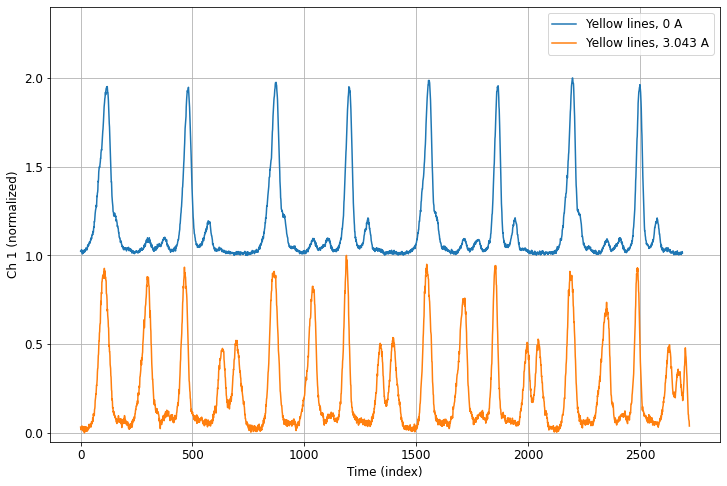

In [24]:
#code from Shelby
##Lab had mentioned only needing 2-3 cycles so to get 4 for the data analysis I had to use the partial cycle at the start of our scan
## and the the partial cycle at the end to get 4 full cycles. This is why the scan doesn't start at the start of a cycle and why
## parts of the following analysis are done more manually than in the above analysis of the green line.
# Build normalized and trimmed data
# Slice found by eye with iteration on plot
# putting into new numpy array resets indices to start at zero
def normalize_array(ydata):
    normed_data= (ydata-ydata.min())/(ydata.max()-ydata.min())
    '''
    Normalizes data set to lie within [0,1] range
    '''
    ## You fill in ##
    return normed_data
yell0h= Yellow_B0[Yellow_B0.TIME<0.1060]
yellbh=Yellow_1817[Yellow_1817.TIME<0.1061]
#yellbh.reset_index(inplace = True)
yel_0 = normalize_array(yell0h['CH1'])
yel_B = normalize_array(yellbh['CH1'])
                
# Offset and normalize-scale the data sets
plt.ylim(-0.05,2.4)
plt.xlabel(r'Time (index)')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(1+yel_0,'-', label='Yellow lines, 0 A')
plt.plot(yel_B,'-', label='Yellow lines, 3.043 A')
plt.legend() 
plt.grid(); 

### Find the peaks

Work only on the $I=1.817$ A data. Locate the peaks, and plot the data with markers to make sure you have the correct ones. You should have 24 peaks.

Peak  Loc   Width   Height
  1   105    50.0    0.88
  2   300    42.4    0.87
  3   386    25.0    0.10
  4   466    34.7    0.90
  5   633    30.6    0.47
  6   696    40.6    0.49
  7   864    42.9    0.91
  8  1038    38.8    0.83
  9  1123    25.6    0.11
 10  1189    30.6    0.97
 11  1340    26.4    0.50
 12  1397    37.0    0.51
 13  1548    40.3    0.94
 14  1712    40.4    0.76
 15  1791    24.3    0.11
 16  1853    28.4    0.94
 17  1996    24.3    0.51
 18  2046    35.0    0.52
 19  2191    38.5    0.87
 20  2350    42.7    0.71
 21  2425    24.6    0.11
 22  2488    27.9    0.93
 23  2630    32.3    0.47
 24  2703    13.1    0.48


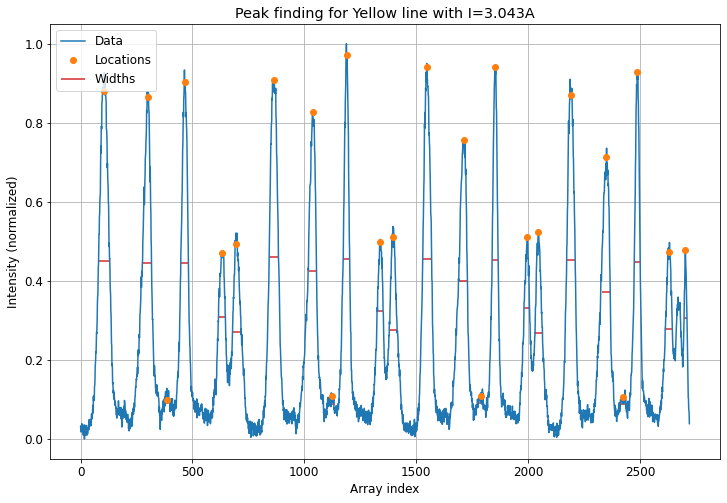

In [25]:
## Call the peak finding routine.  
## You may want to increase the smoothing a little.  The yellow lines are noisier
## Function to locate the peaks, plot them, and return the important data
from scipy.signal import find_peaks

## function to smooth data with gaussian convolution.
from scipy.ndimage import gaussian_filter1d

#had to change rel_prom to really small to get those extra side peaks
#increased smoothing to 5

def find_and_plot_peaks(ydata, title='Data', makeplot=True, min_width=50, min_dist=150, rel_prom=0.020, smoothing=5):
    '''
    Function locates peaks using SciPy.signal find_peaks() and plots
    the results (optionally).  Returns two arrays: 'peaks' which holds
    the index of each peak maximum and 'widths' which holds the FWHM of
    each peak.
    '''
    # Below does the work.  The height parameter makes the function only look 
    # for peaks higher than halfway up the tallest peak.
    
    smooth_data = gaussian_filter1d(ydata,smoothing)

    peaks, pk_props = find_peaks(smooth_data, width = min_width, distance=min_dist, prominence=ydata.max()*rel_prom)
    
    height = []
    ix = 0
    print('Peak  Loc   Width   Height')
    for pk, prop in zip(peaks, pk_props['widths']): 
        ix += 1
        print('{:3d}  {:4d} {:7.1f}  {:6.2f}'.format(ix, pk, prop, ydata[pk]))
        height.append(ydata[pk])
    if makeplot:
        plt.grid()
        plt.title('Peak finding for Yellow line with I=3.043A')
        plt.ylabel(r'Intensity (normalized)')
        plt.xlabel(r'Array index')
        plt.plot(ydata,'-',label='Data')
        plt.plot(peaks, ydata[peaks],'o', color='C1', label='Locations')
        plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
                   xmax=peaks+pk_props['widths']/2, color = 'C3', label='Widths')
        plt.legend();
    
    return peaks, pk_props['widths'], height

# Smoothing function applied to improve peak-center location
# You will need to set parameters as well as data file

peaks,widths,height = find_and_plot_peaks(yel_B,min_width=10,min_dist=50,title='Green line with I=3.6A')

## Separate the two yellow series

Because the yellow-lines scan contains two different wavelengths, you need to separate the peaks associated with 577 nm from the peaks associated with 579 nm.  One way to do this is by creating index lists to separate the two groups of peaks.  The 579 nm peaks are split from the central peak that is followed by a small side peak; the 577 nm peaks come from the other set.  To create the index lists, it is easiest to just write them by hand.  For example, for the 577 nm series, the central peaks are at indices 1, 7, 13, and 19 in the `peaks` array, and the side peaks are 1 up and 1 down from these.  Create an index list by
```
idx577 = np.array([0,1,2,6,7,8,12,13,14,18,19,20], dtype=int)
```
and the 579 nm series is found by adding 3 to all of the 577 nm indices:
```
idx579 = idx579 + 3
```

**Important:** the indices are NOT the peak locations, just the indices of the array that is `peaks`.  The peak locations would be at `peaks[idx577]`, for example.

Then use these indices to separate the peaks array into two independent sets.  These can then be analyzed in a manner identical to what was done with the green lines.  For each group:
* Locate the cental peaks for each with a slice, except skip by 3 rather than 9, and start at 1 rather than 4.
* Fit the central peaks to a polynomial curve and make a calibration function.
* Plot the data set to x-values determined by the calibration function to make sure it's right.
* Make a table of peak locations in units of FSR
* Calculate differences of the side peaks from the central peaks, and average across the scan.
* Rescale those differences in units of $\mu_BB$
* Make a table that shows the rescaled differences along side the values expected from theory.

In [26]:
## Make the index arrays for the central peaks for the two series
##Manually input peak arrays since one of the cycles is split on the plot

idx577 = np.array([2,3,4,8,9,10,14,15,16,20,21,22])
idx579 = np.array([0,1,5,6,7,11,12,13,17,18,19,23])

## Make two arrays of peak locations, one for 577 nm and one for 579 nm
peaks577 = peaks[idx577]
peaks579 = peaks[idx579]

print('577 nm peaks at ',peaks577)
print('579 nm peaks at ',peaks579)


577 nm peaks at  [ 386  466  633 1123 1189 1340 1791 1853 1996 2425 2488 2630]
579 nm peaks at  [ 105  300  696  864 1038 1397 1548 1712 2046 2191 2350 2703]


## Analysis for 577 nm Yellow lines

### Get conversion calibration

Fit the central peaks for the 577 nm part of the scan to get the coefficients to convert peak locations to FSR units, as was done for the green lines.

In [27]:
## Locate central peaks
from lmfit.models import LinearModel

line = LinearModel()

## Recommended:
## Make a function to do the work, with model as a passed object.
## The return is the fit parameters structure

def model_fit_and_plot(xdata, ydata, model=LinearModel()):
    '''
    Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters
    '''
    param_guess = model.guess(ydata, x = ydata)
    model_fit = model.fit(ydata, param_guess, x = xdata)
    # Complete the function
    return model_fit.params

centrals577 = [peaks[3],peaks[9],peaks[15],peaks[21]] #

## Fit to polynomial
## Import the model
from lmfit.models import PolynomialModel

## set the model to make a 3rd-order ploynomial
curve = PolynomialModel(degree=3)


num = []
for i in range(len(centrals577)):
    num.append(i)
## Fit.  NOTE: the y-valuse should be the list of integers (peak numbers), and the x-values 
## should be the peak locations.
yel577_curve = model_fit_and_plot(centrals577, num, model = curve)
print(yel577_curve)

Parameters([('c0', <Parameter 'c0', value=-0.5773350528004138 +/- 4.62e-15, bounds=[-inf:inf]>), ('c1', <Parameter 'c1', value=0.0011726254690426477 +/- 1.32e-17, bounds=[-inf:inf]>), ('c2', <Parameter 'c2', value=1.5047353632812064e-07 +/- 1.02e-20, bounds=[-inf:inf]>), ('c3', <Parameter 'c3', value=-1.7635776368450325e-11 +/- 2.28e-24, bounds=[-inf:inf]>)])


### Make a calibration function

And then plot the original data against the x-values using the calibration.  You should see the 577 centers at evenly spaced values of the free spectral range.

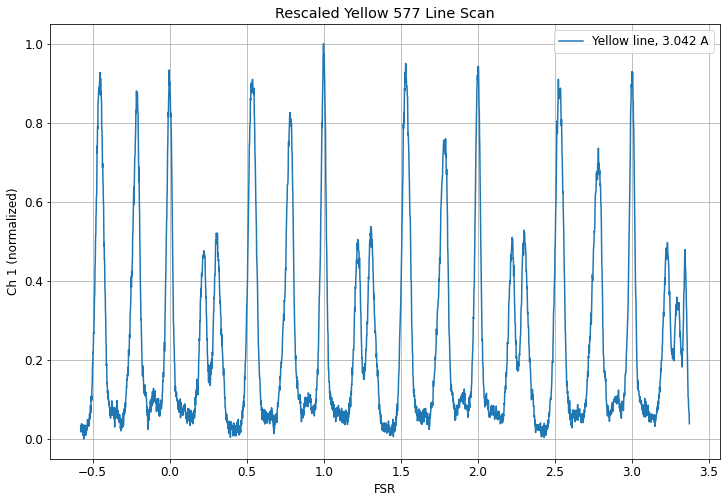

In [28]:
def yel577_cal(x,model=curve,params=yel577_curve):
        return model.eval(params, x=x)
    
x=[]
for i in range(len(yel_B)):
    x.append(i)
## Make an x-value array from the calibration function.  
## This array will reset the horizontal axis to units of FSR
x_yel = yel577_cal(x)

# Plot
plt.title('Rescaled Yellow 577 Line Scan')
plt.xlabel(r'FSR')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(x_yel, yel_B,'-', label='Yellow line, 3.042 A')
plt.legend() 
plt.grid(); 


### Print a table

Show the 577 nm peak locations in units of FSR

In [29]:
## Useful to make a DataFame for display
ypeaks_calibrated = []
for i in range(len(peaks577)):
    ypeaks_calibrated.append(yel577_cal(peaks577[i]))
height = np.round(height, decimals = 2)
Yellow577_scan_peaks = pd.DataFrame(list(zip(ypeaks_calibrated, height)), columns = ['FSR', 'Height'])

print('Locations of 577 nm peaks:')
Yellow577_scan_peaks
#ypeaks_calibrated                        

Locations of 577 nm peaks:


,FSR,Height
0,-1.032959e-01,0.88
1,1.110223e-16,0.87
2,2.207569e-01,0.10
3,9.043133e-01,0.90
4,1.000000e+00,0.47
5,1.221740e+00,0.49
6,1.904191e+00,0.91
7,2.000000e+00,0.83
8,2.222473e+00,0.11
9,2.899665e+00,0.97


### Calculate differences and average

Repeat what was done for green, except now there will only be one center peaks and two side peaks.

In [30]:
## Need only 3 elements in the average arrays

yellow_FSR = np.array(ypeaks_calibrated)
y577 = np.zeros(3)
y577_std = np.zeros(3)

for i in range(0,3):
    y577[i] = np.mean(yellow_FSR[i::3] - yellow_FSR[1::3])
    y577_std[i] = np.std(yellow_FSR[i::3] - yellow_FSR[1::3])

## Build uncertainty arrays (optional)
Yellow577_peaks = pd.DataFrame({'Shift (FSR)':up.uarray(y577,y577_std)},index=range(-1,2))

## Convert to mu*B units
Yellow577_peaks['Energy (B*mu)']=Yellow577_peaks/conv_fact_yellow

## Add in theory predictions from exercises.
##Have 9 theory prediction values since theory says each of the 3 lines we observe should be 3, so I am using
## the central line shift for each delta m_J as the theory value.
Yellow577_peaks['Theory (B*mu)']=[-1.17,0.00,1.17]

print('Averaged locations of 577 nm peaks:')
Yellow577_peaks

Averaged locations of 577 nm peaks:


,Shift (FSR),Energy (B*mu),Theory (B*mu)
-1,-0.0988+/-0.0032,-0.514+/-0.020,-1.17
0,0.0+/-0,0.0+/-0,0.00
1,0.2229+/-0.0023,1.161+/-0.027,1.17


## Analysis for 579 nm Yellow lines

### Get conversion calibration

Fit the central peaks for the 579 nm part of the scan to get the coefficients to convert peak locations to FSR units, as was done for the green lines.

In [31]:
## Select central peaks
## Select manually since start of scan isn't the start of a cycle

centrals579 = [peaks[0],peaks[6],peaks[12],peaks[18]]

yel579_curve = model_fit_and_plot(centrals579, num, model = curve)


### Make a calibration function

And then plot the original data against the x-values using the calibration.  **Now, You should see the 579 centers at evenly spaced values of the free spectral range.**

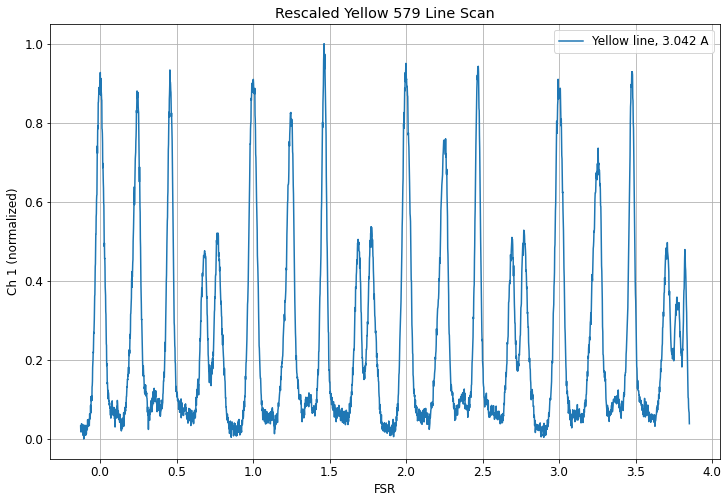

In [32]:
## define the calibration function

def yel579_cal(x,model=curve,params=yel579_curve):
    return model.eval(params, x=x)
        # Complete

x2=[]
for i in range(len(yel_B)):
    x2.append(i)
## Make an x-value array from the calibration function.  
## This array will reset the horizontal axis to units of FSR
x_yel2 = yel579_cal(x2)

# Plot
plt.title('Rescaled Yellow 579 Line Scan')
plt.xlabel(r'FSR')
plt.ylabel(r'Ch 1 (normalized)')
plt.plot(x_yel2, yel_B,'-', label='Yellow line, 3.042 A')
plt.legend() 
plt.grid(); 

### Print a table

Show the **579 nm peak locations** in units of FSR

In [33]:
## Useful to make a DataFame for display
peaks_calibrated = []
for i in range(len(peaks579)):
    peaks_calibrated.append(yel579_cal(peaks579[i]))
height = np.round(height, decimals = 2)
 ## Complete the dataframe

Yellow579_scan_peaks = pd.DataFrame(list(zip(peaks_calibrated, height)), columns = ['FSR', 'Height']
   # Complete
)

print('Locations of 579 nm peaks:')
Yellow579_scan_peaks

Locations of 579 nm peaks:


,FSR,Height
0,0.000000,0.88
1,0.243941,0.87
2,0.767505,0.10
3,1.000000,0.90
4,1.246687,0.47
5,1.772671,0.49
6,2.000000,0.91
7,2.250490,0.83
8,2.770644,0.11
9,3.000000,0.97


### Calculate differences and average

Repeat what was done for the 577 nm group above.

In [35]:

## Need only 3 elements in the average arrays
#Calculating mean and standard deviations for the central peaks and peaks following the central peaks.
yellow_FSR = np.array(peaks_calibrated)
y579 = np.zeros(2)
y579_std = np.zeros(2)

for i in range(0,2):
    y579[i] = np.mean(yellow_FSR[i::3] - yellow_FSR[0::3])
    y579_std[i] = np.std(yellow_FSR[i::3] - yellow_FSR[0::3])

## Build uncertainty arrays (optional)
Yellow579_peaks = pd.DataFrame({'Shift (FSR)':up.uarray(y579,y579_std)},index=range(0,2))



print('Averaged locations of 579 nm peaks:')
Yellow579_peaks

#For the first central peak, the peak before is at the end of the scan, so the central peak can be assumed to be at 4.0 and then
## subtract the last peak from it.
mean=-1*np.mean([4.0-yellow_FSR[11], yellow_FSR[9]-yellow_FSR[8],  yellow_FSR[6]-yellow_FSR[5], yellow_FSR[3]-yellow_FSR[2]])
std=np.std([4.0-yellow_FSR[11], yellow_FSR[9]-yellow_FSR[8],  yellow_FSR[6]-yellow_FSR[5], yellow_FSR[3]-yellow_FSR[2]])

print(Yellow579_peaks)
#Creating a dataframe for the shift for the peak before the central peak
new=pd.DataFrame({'Shift (FSR)':up.uarray(mean,std)},index=range(-1,0))

#Creating rows for the central peak shift and shift of the peak after the central peak, then adding to the above dataframe
new_row1=pd.Series([up.uarray(y579[0],y579_std[0])], index=new.columns)
new2= new.append(new_row1,ignore_index=True)
new_row2=pd.Series([up.uarray(y579[1],y579_std[1])], index=new.columns)
new3= new2.append(new_row2,ignore_index=True)

##Converting to mu*B units
new3['Energy (B*mu)']=new3/conv_fact_yellow

#Add in theory predictions from exercises
new3['Theory (B*mu)']=[-1.0,0.0,1.0]

new3

Averaged locations of 579 nm peaks:
     Shift (FSR)
0        0.0+/-0
1  0.249+/-0.004


,Shift (FSR),Energy (B*mu),Theory (B*mu)
0,-0.217+/-0.023,-1.13+/-0.12,-1.0
1,0.0+/-0,0.0+/-0,0.0
2,0.249+/-0.004,1.295+/-0.033,1.0
